# Algorithms for Bayesian A/B testing 


# 1. Epsilon-Greedy algorithm

Suppose that we have software serving 2 advertisements A and B and we want to know which one have better conversion rate. 

The idea is not blindly serve ad A and ad B an equal number of times but *adapt* us to the data we have collected so far. If ad A is performing better, we want to show it more.

Even with this adaptive system, we can still do traditional A/B testing in any stage of the eperiment. Remember that the contingency table built for calculating $\chi^2$-test does not require the size of each group to be the same. The important difference here is that in tradicional A/B testing we don't adapt to the data and just keep blindly serving each ad in a predefined way, while following Epsilon-greedy algorithm the mahcine will adapt the data based on performance of each ad.

## How does Epsilon-Greedy work?

1. Choose a small number $0<\varepsilon<1$. This will be the probability of exploration.

2. In a loop we generate a random number $r$. 
* If $r<\varepsilon$, we explore, i.e. we show random advertisement.
* If $r\geq\varepsilon$, we exploit, i.e. we show the best advertisment as determined by $CRT = \frac{\# clicks}{\# impresions}$

A pseudocode for this is as follows:

## Pros & Cons

1. It does the same thing forever: even when ad A is statistically significant better than ad B, it might still sometimes choose ad B.
* Suppose that the test has converged and ad A is better than ad B. Suppose that our reward function is:

$$Return(n) = \begin{cases} 1&  \text{if }n=click\\
0 & \text{else}\end{cases}$$

After $N$ impressions, we have that:

$$E(Return) = N(1-\dfrac{\varepsilon}{2})$$

Therefore, for $\varepsilon = 0.1$, we get $E(Return) = 0.95N$ rather than $N$ which is still better than traditional A/B testing with no adaptation at all. 

That means that in the long run we get 95% of best possible reward, if $\varepsilon = 0.1$. Can we improve this?



## 2. Upper Confidence Bound

### The Chernoff-Hoeffding bound

Let $N>0$. Then exists $\varepsilon>0$ such that:

$$P(\hat{\mu}>\mu+\varepsilon)\leq e^{-2\varepsilon^2N}\text{    and    } P(\hat{\mu}<\mu-\varepsilon)\leq e^{-2\varepsilon^2N}$$

In other words:

$$P(|\hat{\mu}-\mu|\leq\epsilon)> 1-2{e^{-2\epsilon^2N}}$$

As we want to get the highest return possible, we are only interested in the upper bound. IF we skip the math behind it, for each arm $j$ we choose:

$$\epsilon_j = (\dfrac{2\ln N}{N_j})^{1/2}$$

where $N$ is the number of total games played so far and $N_j$ is teh number of times played in arm $j$.

With this in mind, the UCB1 Algorithm pseudocode is as follows:

## Bayesian Paradigm: Recap

In Bayesian statistics, we treat the parameter $\theta$ as a random variable too, so it has its own distribution and the shape of that distribution will tell us how confident we are about of any value for that parameter. In particular, we apply Bayes rules to help us with this:

$$P(\theta|X)= \dfrac{P(X|\theta)P(\theta)}{P(X)}= \dfrac{P(X|\theta)P(\theta)}{Z}$$

where $Z$ is a normalizing constant.

* $P(X|\theta):$ is the likelihood, how likely is this data given current $\theta$?
* $P(\theta)$: prior probability, old beliefs about $\theta$
* $P(\theta|X)$: posterior, new belief about $\theta$ after seeing data

All the terms from the equation below are probability distributions, e.g. $P(X)= \int P(X|\theta)P(\theta)d\theta$. In general terms, all these expressions are very hard or impossible to solve. 

For this reason, we need to introduce a very elegant method to solve this problem, called **conjugate priors** which allow us to find solutions for $P(\theta|X)$.

## 3. Conjugate priors in Click-through-rate problem

If we choose specific distributions for $P(X|\theta)$ and $P(\theta)$, then we can make $P(\theta|X)$ have the same type of distribution as $P(\theta)$.

We know that likelihood for CRT is Benoulli:

$$P(X|\theta)= \prod_{i=1}^N\theta^{x_i}(1-\theta)^{1-x_i}$$

In this situation, $\theta$ must be a parameter between 0 and 1, because it's the probability of a click. What distributions go between 0 and 1?

One of them is the Beta distribution:

$$\theta\cong Beta(a, b)= \dfrac{\theta^{a-1}(a-\theta)^{b-1}}{B(a,b)}$$

where $B(a,b) = \Gamma(a)\Gamma(b)/\Gamma(a+b)$ and $\Gamma$ is the gamma function which generalize factorial function for real numbers.

After some math, if we assume that $\theta$ has Beta distribution, we have:

$$P(\theta|X)= Beta(a', b')$$

where $a' = a+\sum^N x_i$, $b'= b+ N-\sum^Nx_i$. In particular:

$a' = a+ \#clicks, b' = b+\#no\_clicks$

### How do we choose original a and b parameters?

We have that $Beta(1, 1) = Uniform(0,1)$. It makes sense set these values for the prior distribution in the context of CRT, because if we don't know anything, all CRT are equally probable. Also, note that as we collect data gets dlarge, influence of priors becomes very small.


## 4. Conjugate priors implementation

First we import some libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
plt.rcParams["figure.figsize"]= (8,5)

Now we will set the number of trials and the bandit probabilities:

In [3]:
NUM_TRIALS = 2000
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]

Now we will construct the class Bandit:

In [4]:
class Bandit(object):
  def __init__(self, p):
    self.p = p
    self.a = 1
    self.b = 1

  def pull(self):
    return np.random.random() < self.p

  def sample(self):
    """
    Sampling from Beta distribution
    """    
    return np.random.beta(self.a, self.b)

  def update(self, x):
    self.a += x
    self.b += 1 - x


Also we construct a function which plots the distributions after the trials:

In [5]:

def plot(bandits, trial):
  x = np.linspace(0, 1, 200)
  for b in bandits:
    y = beta.pdf(x, b.a, b.b)
    plt.plot(x, y, label="real p: %.4f" % b.p)
  plt.title("Bandit distributions after %s trials" % trial)
  plt.legend()
  plt.show()



And finally, a function to run our experiment:

current samples: ['0.5287', '0.4567', '0.7761']


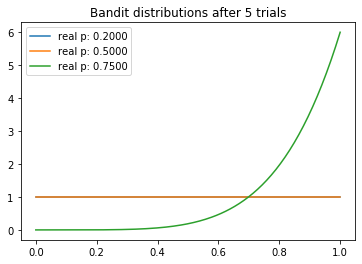

current samples: ['0.6139', '0.3495', '0.9556']


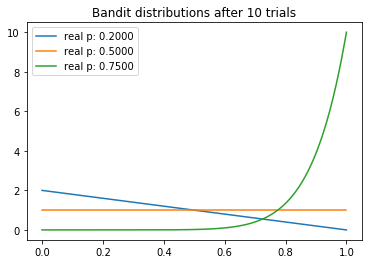

current samples: ['0.0113', '0.7829', '0.7390']


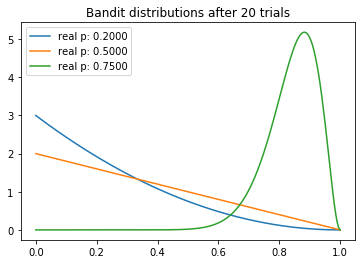

current samples: ['0.1353', '0.3179', '0.7342']


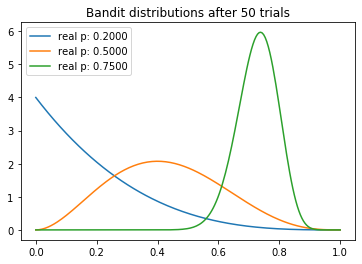

current samples: ['0.1607', '0.3232', '0.7103']


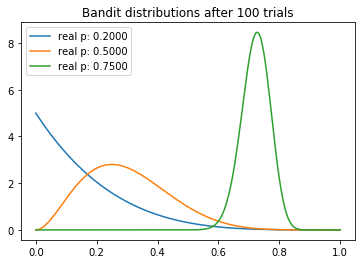

current samples: ['0.2069', '0.1799', '0.6995']


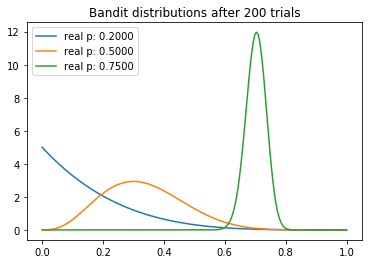

current samples: ['0.2167', '0.4337', '0.7341']


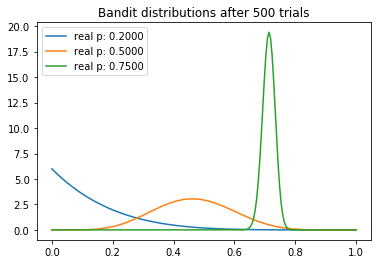

current samples: ['0.0693', '0.3519', '0.7187']


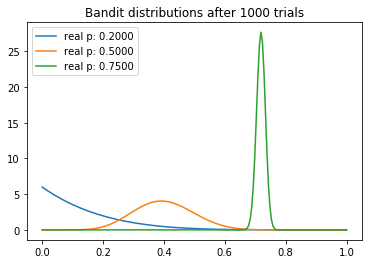

current samples: ['0.2729', '0.4545', '0.7074']


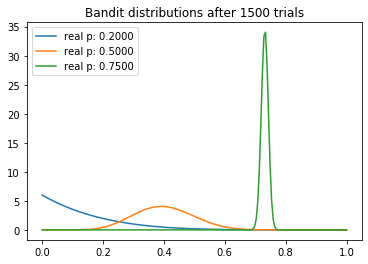

current samples: ['0.1933', '0.2857', '0.7454']


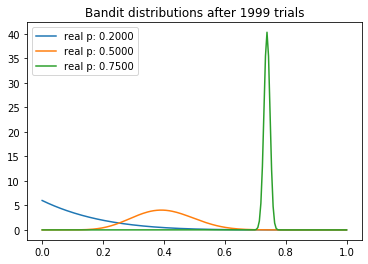

In [6]:

def experiment():
  #initialize and array fo bandits  
  bandits = [Bandit(p) for p in BANDIT_PROBABILITIES]

  sample_points = [5,10,20,50,100,200,500,1000,1500,1999]

  for i in range(NUM_TRIALS):

    # take a sample from each bandit
    bestb = None #bandit which we eventually pull
    maxsample = -1
    allsamples = [] 
    for b in bandits:
      sample = b.sample() #we sample from the bandit
      allsamples.append("%.4f" % sample)
      if sample > maxsample:
        maxsample = sample #keep track of the maximum
        bestb = b
    if i in sample_points:
      print("current samples: %s" % allsamples)
      plot(bandits, i)

    # pull the arm for the bandit with the largest sample
    x = bestb.pull()

    # update the distribution for the bandit whose arm we just pulled
    bestb.update(x)


#if __name__ == "__main__":
experiment()


The lower performing bandit distributions never become sharp, they are very flat compared with the best performing bandit. In other words, we are almost sure that the true CRT was lower, so there is no need to explore further.